![UVic logo](https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/v1406151713/wptak6xuezyh36b1hbty.png)

# **ECE 471/536 Spring 2021: Computer Vision**
## Assignment 2: Convolutions and Histogram of Oriented Gradients (HOG)
### Due date: Fabruary 22, 10 PM PST

> Student: Nolan Caissie, V00878989
---
Abstract: *This assignment is composed of four main programming activities: 1) the manual implementation and evaluation of a convolution function; 2) the manual extraction of the Histogram of Oriented Gradients (HOG) features; 3) a block normalization step for the HOG features calculated; 4) a comparison between your hand-crafted features with those from scikit-images' impelmentation of HOG  (using the cosine similarity metric).* 
 

## **1. Instructions:** follow the intructions provided on a sequential manner. 
### 1.0 **Identification** 
Please enter your name and V number on the text cell above.

### 1.1 **Submission package**
Your final submission package must be submitted using the [BrightSpace](https://https://bright.uvic.ca/d2l/home)  platform. You will find this assignment's specific page under **Course Tools > Assignments**. Your submission package consists of a *.zip* file containing:

1.   *.ipynb* file: your modified version of this Google Colab template. Place your complete assignment solution/information in this version. 

### 1.2 **Coding considerations**
* In previous years we asked students to complete assignments offline by installing either MATLAB or a Python environment in their computers. In order to standardize the submissions and guarantee that everyone has access to the same Python environment, all assignments are going to be described (by us) and completed (by you) using the same Google Colab template script.
* Google Colab offers a Python environment that can be accessed in your browser and executed using Google Cloud, so no local installation is necessary. It makes the setting-up process significantly easier! Please read [this quick tutorial](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb) notebook on Google Colab/Python.

### 1.3 **Creating your Google Colab submission file**

* Modify this template with your solutions to the assignment. You will find "**TO-DO**" indicators throughout the assingment highlighting portions of the code you are asked to complete, as well as their worth. 
* Colab notebooks are divided into individual cells. You can execute the code inside of a given cell by pressing **CTRL+ENTER**, or that of all cells by pressing **CTRL+F9**. Variables must be "executed" in a cell before being used by subsequent ones (the same goes for libraries imported). Note that some cells of this assignment contain flags that must by changed (and executed) before you move forward.
* If you completed the whole assignment, make sure that simply pressing "**CTRL+F9**" executes all cells correctly. **This is going to be the first marking step we will execute when evaluating your submission**.  

### 1.4 **Use of open source code**

* The use of small segments of freely-available code is permitted. However, it is **extremely important** that you indicate in your in-code comments where these are used, as well as their sources. Failure to do so can be considered plagiarism, which is a serious offence. Learn more about detection mechanisms and consequences of plagiarism at UVic [here](https://www.uvic.ca/library/research/citation/plagiarism/). Note that the programming assignments are designed so that most of their content should be created by you.     
* A number of functions/algorithms are already implemented by libraries we will use (e.g., [OpenCV](https://opencv.org/), [scikit-learn](https://scikit-learn.org/stable/)), however you should not use them unless otherwise instructed to do so. Mannualy coding some of these function is an important part of the learning process. 


In [1]:
READ_THE_INSTRUCTIONS_FLAG = True

# **2. Programming: Histogram of Oriented Gradients and convolutions (100 points)**

### **2.0 Convolution function** (24 points)

Convolutions are important mathematical operations where a function is modified by a second one. In a discrete setting, convolution and cross-correlation can be used to apply diverse kernels in multi-dimensional matrices (e.g., images). In this part of the assignments you are asked to mannualy implement a function that executes a convolution (actually cross correlation: read note in the next code block).  

In [2]:
from matplotlib import pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
import sys
import cv2
import os
import numpy as np
import fnmatch

print('-'*40)
print ('Python version: {}'.format(sys.version))
print('OpenCV version: {}'.format(cv2.__version__))

if not READ_THE_INSTRUCTIONS_FLAG:
  raise Exception('Please go back and read the instructions.')
else:
  print('\nThank you for reading the instructions.')
print('-'*40)

# helper functions

def pltImg(img, title=None, ori="horizontal", colorb = True, color_map='gray'):  # not mandatory, but useful
  plt.imshow(img,cmap=color_map)
  if colorb:
    plt.colorbar(orientation=ori)
  if title:
    plt.title(title)
  return plt

# TO-DO (15 points): Implement a function that performs a convolution following the skeleton provided. You 
# should use a maximum of ksize*ksize iterations in your "for" loop. For example: given a 
# 3x3 kernel, you can use a maximum of 9 iterations on your convolution's "for" loop. Your 
# function should accept input matrices of any size, as long as they are at least the 
# same size as the convolutional kernel.   

# Note 1: we are implementing a convolution function that uses padding so that the 
# output image does not change its dimensions. As mentioned in Lecture 6, in some feature extraction
# networks and many other settings this is not the desired behaviour (i.e., images
# are supposed to change their dimensions).

# Note 2: consider that the input kernels are square matrices with an odd number of 
# rows and columns (e.g., 3x3, 5x5, 7x7, 9x9). 

# Note 3: for simplicity (and to conform with most functions from popular libraries)
# we are actually implementing a cross-correlation operation. Remember: to
# implement a proper convolution, it suffices to rotate a kernel around its
# center (i.e., horizontal then vertical reflection). More details provided in the following
# code cell.

#SO... it looks like for cross correlation what we are doing is taking a kernel with a 
#certain "k" value (which will tell us kinda how big the kernel will be) and then it says
#"Can think of as a 'dot product' between local neighbourhood and kernel for each pixel
#I guess like wherever the kernel is zero (like outside of its dimensions) that is where
#the 'convolution'/cross correlation will be zero? and then we shift the kernel or input
#around and repeat this for every neighbourhood
#ESSENTIALLY, multiply each pixel in the kernel in a nested for loop with the pixels
#in a neighbourhood centered around a pixel in the input image and then add up all of these
#multiplications. This operation will map to 1 pixel in the output image


def my_padded_conv2D(kernel, matrix, pad_value=0):
 
  # steps: 

  # 1. create a matrix to receive the results
  
  if matrix.shape < kernel.shape:
    raise Exception('The kernel must have dimensions greater than or equal to the image')
  result = np.zeros(matrix.shape, np.float32)
  result_pixel = 0
   
  # 2. pad the image with the constant value indicated (default 0) based on the kernel provided
  # Add zero padding to the input image 
  #got some help from these two sites
  
  #https://www.kaggle.com/thesherpafromalabama/manual-image-convolution-zero-padding
  #https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
  
  #create a matrix of the required size for padding
  matrix_padded = np.zeros((matrix.shape[0] + (kernel.shape[0]-1), matrix.shape[1] + (kernel.shape[1]-1)))   
  #couldn't figure out a smarter way to do this... but here, I create a "horizontal" and "vertical" padding array
  #based on the size of the kernel, input image, and padded image matrix so that the padded values can be placed
  #into the image 
  #(NOTE:this is unecessary if the pad_value is just = 0 because this code will naturally pad with zeros using np.zeros)
  pad_value_ax = np.full((kernel.shape[0]//2, matrix_padded.shape[1]),pad_value)
  #print(pad_value_ax)
  pad_value_ay = np.full((matrix_padded.shape[0], kernel.shape[1]//2), pad_value)
  #print(pad_value_ay)
  #Here, the padded values are replaced (just in case a non-zero padding value is entered)
  #another NOTE: remember that you are indexing matrix_padded[height, width]
  matrix_padded[:(matrix_padded.shape[0]), :(kernel.shape[1]//2)] = pad_value_ay
  matrix_padded[:(matrix_padded.shape[0]), -(kernel.shape[1]//2):] = pad_value_ay
  matrix_padded[:(kernel.shape[1]//2), :(matrix_padded.shape[1])] = pad_value_ax
  matrix_padded[-(kernel.shape[1]//2):, :(matrix_padded.shape[1])] = pad_value_ax
  #print(matrix_padded)
  #matrix_padded[(-kernel.shape[0]//2):, (-kernel.shape[1]//2):] = pad_value
  #print(matrix_padded)
  #Here we will place the image into the center of the padded matrix
  #note that the negative indexing here (-(kernel.shape[]//2)) is indexing the element that is "kernel.shape[]//2"
  #away from the end of the array (i.e. if it was -1 that would be the last value, if -2 that would be the second last value)
  matrix_padded[(kernel.shape[0]//2):-(kernel.shape[0]//2), (kernel.shape[1]//2):-(kernel.shape[1]//2)] = matrix

  # 3. fill the "result" matrix using a maximum of ksize*ksize iterations (e.g., for 
  # a 3x3 kernel, a maximum of 9 iterations in a loop)  
  #this method does not fill the result with ksize*ksize iterations - need to fix
  for x in range(matrix.shape[0]):     # Loop over every pixel of the image
    for y in range(matrix.shape[1]):
      # element-wise multiplication of the kernel and the image
      result[x,y]=(kernel*matrix_padded[x:x + kernel.shape[0], y:y + kernel.shape[1]]).sum()

  #for i in range (0, matrix.shape[0]):
  #  for j in range (0, matrix.shape[1]):
      #so here, you multiply each value in the row by traversing the columns of that row
      #and as you are doing this you sum them all. You continue traversing each row and
      #each column and multiply and sum until you have done this for every single pixel in 
      #the kernel.
   #   for u in range (0,kernel.shape[0]): 
   #     for v in range (0,kernel.shape[1]):
          #for convolution it is + u and v and for cross correlation it is - u and v
          #the variable result_pixel will map to a single pixel G[i,j] in the output image
          #this pixel now value now needs to be placed in the value i,j that the kernel is
          #centered on (look above in the variable of the i,j for loop)
    #      result_pixel += kernel[u,v]*matrix[i-u,j-v]
      #here, we need to index the position of the output image for which the kernel
      #was centered on in the input image
     # result[i,j] = result_pixel 
      #result_pixel = 0

  assert (result.shape == matrix.shape),'The dimensions of input and output should be the same.'
  return result


----------------------------------------
Python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
OpenCV version: 4.1.2

Thank you for reading the instructions.
----------------------------------------


In [3]:
# TO-DO (9 points total): test your convolution function with the three scenarios created below. 
# We will use OpenCV's filter2D function as a reference for the desired, correct results. 

# Note: both your "my_padded_conv2D" function and OpenCV's "cv2.filter2D" are actually implementing cross correlation, as
# stated in OpenCV's documentation of the function: "The function does actually compute correlation,
# not the convolution" (https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)
# To implement convolution, you would simply rotate the kernel to be used with your function 180 degrees. This is not 
# necessary in this assignment.   

# Scenario 1 (3 points) - simple 3x3 identity matrix kernel and square input matrix
kernel1 = np.eye(3).astype(np.float32)
#print(kernel1)
input1 = np.arange(1,26).reshape((5,5)).astype(np.float32)
#print(input1)
result1 = my_padded_conv2D(kernel1,input1)
result1_reference = cv2.filter2D(input1, -1, kernel1, borderType=cv2.BORDER_CONSTANT)
assert (result1_reference == result1).all(), 'Incorrect result in scenario 1.'

# Scenario 2 (3 points) - simple 5x5 identity matrix kernel and WxH input matrix
kernel2 = np.eye(5).astype(np.float32)
#print(kernel2)
input2 = np.arange(1,8193).reshape((128,64)).astype(np.float32)
#print(input2)
result2 = my_padded_conv2D(kernel2,input2)
#print(result2)
result2_reference = cv2.filter2D(input2, -1, kernel2, borderType=cv2.BORDER_CONSTANT)
#print(result2_reference)
assert (result2_reference == result2).all(), 'Incorrect result in scenario 2.'

# Scenario 3 (3 points) - 7x7 random-valued kernel with WxH random-valued matrix
kernel3 = np.random.randint(1, 1000, 49).reshape(7, 7).astype(np.float32)
input3 = np.random.randint(1, 1000, 200).reshape(10, 20).astype(np.float32)
result3 = my_padded_conv2D(kernel3,input3)
result3_reference = cv2.filter2D(input3, -1, kernel3, borderType=cv2.BORDER_CONSTANT)
assert (result3_reference == result3).all(), 'Incorrect result in scenario 3.'

print('All results are correct!')

All results are correct!


### **2.1 HOG: Pre-processing, magniture and orientation calculation** (20 points)

**Introduction**: Histogram of oriented gradients (HOG) are popular feature descriptors made hugely popular when used for pedestrian detection in 2005 [1]. These feature descriptors are obtained as the output of an intricate computational pipeline which will be discussed during class (week of Feb. 8), and should be implemented in this part of the assignment. We are going to manually implement all steps until the "Linear SVM" phase of the method (see Figure below from [1]).   

[1] Dalal N, Triggs B. Histograms of oriented gradients for human detection. In 2005 IEEE computer society conference on computer vision and pattern recognition (CVPR'05). 2005 Jun 20 (Vol. 1, pp. 886-893). IEEE.

![HOG Pipeline](https://raw.githubusercontent.com/tunai/storage/master/images/teaching/ece%20473-536/A2/hog_pipeline.jpg)

**Note**: a number of image processing libraries provide efficient and easy-to-use implementations of the Histogram of Oriented Gradients. Although these are recommended for general use, the goal of this assignment is to provide a deeper understanding of the algorithmn as well as an opportunity for hands-on experience in implementing complete Computer Vision pipelines. We are going to compare our results with those from an available implementation later.

**Pre-processing, magniture and orientation calculation**: the choice of color space and use of gamma equalization does not significantly change the performance of the method [1]. Therefore, we are going to skip the gamma correction step. The use of grayscale images only "reduces performance by 1.5%" [1], thus we are going to use that approach for simplicity.  


The working directory is: /content

The files contained within the working directory are as follows:

... Duplicate not found


Image "uvic_totem.jpg" has been downloaded



----------------------------------------

The original shape of the image is (512, 256) 

The shape of the new resized image is (128, 64) 

The maximum pixel intensity value after normalization is 1.0 

The minimum pixel intensity value after normalization is 0.0 



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

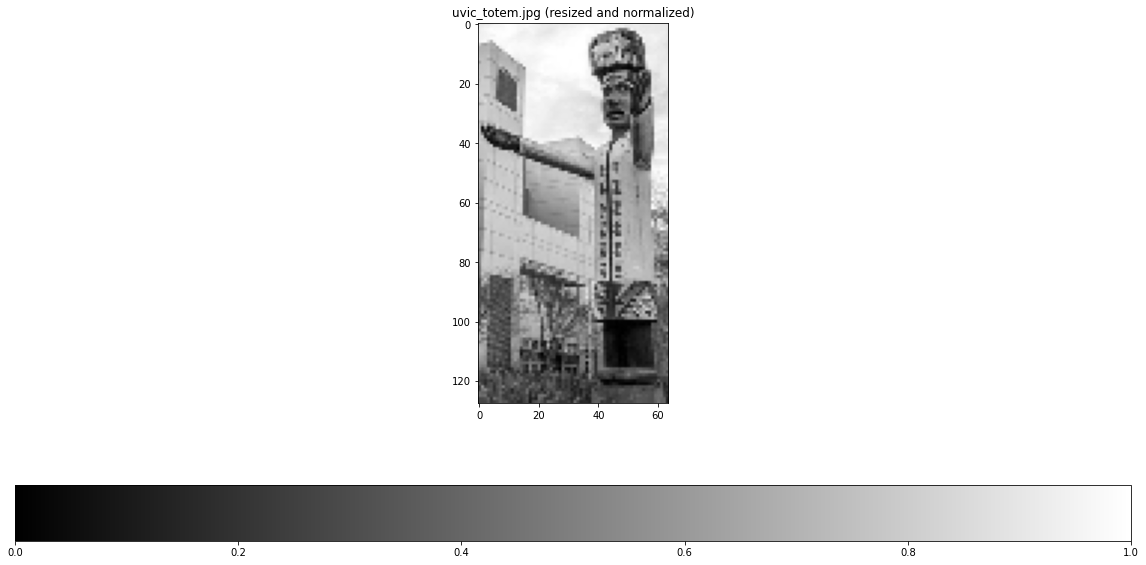

In [4]:
# TO-DO (3 points): Read the image from the address indicated and turn it to grayscale. 
# Resize the image to (64,128) and normalize its pixel intensity values to the [0,1] range. 
# Plot the image after this pre-processing. 

# note 1: check if the image was already downloaded first.
# note 2: for consistency between results, resize the image using the "cv2.INTER_CUBIC"
# interpolation parameter

img_add = "https://raw.githubusercontent.com/tunai/storage/master/images/teaching/ece%20473-536/A2/uvic_totem.jpg"


# 0. check if image was previously downloaded
# if not, download it
#first must retreive the current working directory
working_dir = os.getcwd()
#display current working directory
print('\nThe working directory is: {}\n' .format(working_dir))
#scan the current working directory for files
#I found a similar example on how to do this at : https://realpython.com/working-with-files-in-python/#filename-pattern-matching
ent = []
with os.scandir(working_dir) as entries:
  print('The files contained within the working directory are as follows:\n')
  for entry in entries:
    if entry.is_file():
      print(entry.name)
      ent.append(entry.name)
#if the file we are looking for (uvic_1.jpg) is not found then download the image
if not (any('uvic_totem.jpg' in s for s in ent)):
    print('... Duplicate not found\n')
    print('Downloading Image...')
    os.system('wget {}'.format(img_add))
    for f_name in os.listdir(working_dir):
      if fnmatch.fnmatch(f_name, 'uvic_totem.jpg'):
        print('\nImage "uvic_totem.jpg" has been downloaded\n')

# 1. read the image
img_totem = cv2.imread("uvic_totem.jpg", cv2.IMREAD_GRAYSCALE)

# 2. resize the image
totem_width = 64
totem_height = 128
totem_dim = (int(64), int(128))
img_totem_rz = cv2.resize(img_totem, totem_dim, interpolation = cv2.INTER_CUBIC)


# 3. normalize the image in the [0,1] range
img_totem_norm = img_totem_rz/255
print("\n")
print('-'*40)
print("\nThe original shape of the image is {} \n" .format(img_totem.shape))
print("The shape of the new resized image is {} \n" .format(img_totem_norm.shape))
print("The maximum pixel intensity value after normalization is {} \n" .format(img_totem_norm.max()))
print("The minimum pixel intensity value after normalization is {} \n" .format(img_totem_norm.min()))

cell_size = 8  # 8x8 pixels cells where the histograms of oriented gradients are going to be calculated
n_bin = 9  # number of bins of a given histogram. According to [1], n_bin > 9 did not significantly increase performance. 
#print(img_totem_norm.size)
# plot the image
plt.figure(figsize=(20,10))
pltImg(img_totem_norm, "uvic_totem.jpg (resized and normalized)")


In [5]:
# The authors of [1] used diverse kernels for gradient detection: "We tested 
# gradients computed using Gaussian smoothing followed by one of several discrete derivative masks." 
# However they found that a simple 1-D centered point derivative kernel (i.e., [-1,0,1]) works best. This 
# is what we are going to use.
# Note: using uncentered 1-D point derivative kernels (i.e., [-1,1]: forward and backward difference-based 
# approximations of first-order derivatives) decreased performance in 1.5% [1].

# TO-DO (3 points): define a 1-D centered point derivative kernel (i.e., first order derivative approximation using
# central differences; see Lecture 6) for the calculation of the x-axis gradient ("Gradient in x, G_x") and y-axis gradient
# ("Gradient in y, G_y").
# Apply these kernels to the input image using your "my_padded_conv2D" function. 
# Note: since your function expects square inputs, pad the kernels created with zeros if necessary. 

# here we may need to create a function (can put it a couple cells up) that will check the kernels to see if they are square
# if they are not square then we will have to pad the kernels with 0's.

#sobel operator
#kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
#prewitt operator
#kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
#sobel operator
#kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
#prewit operator
#kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

kernel_x = np.array([[0, 0, 0], [1, 0, -1], [0, 0, 0]])
kernel_y = np.array([[0, 1, 0], [0, 0, 0], [0, -1, 0]])
#print(kernel_y)
gradient_x = my_padded_conv2D(kernel_x, img_totem_norm) 
gradient_y = my_padded_conv2D(kernel_y, img_totem_norm)
#print(gradient_x)
#print(gradient_x.size)
#print(gradient_y)
#print(gradient_y.size)

# TO-DO (13 points): MANUALLY calculate the magnitude and orientation (in degress) matrices from the
# gradient images (i.e., you CAN NOT use cv2.cartToPolar or other functions). 
# The authors of [1] used the "unsigned" gradient (from 0 to 180 degrees, instead of
# 0 to 360 degrees). Do the same by adjusting your mannualy calculated orientation 
# angles (in degrees) to [0,180]. A reference for the first 9 elements of the orientation matrix is provided
# below.  

**Recall**: The magnitude of gradient image $\triangledown I$ is defined as:

$|\triangledown I| = \sqrt{(\frac{\delta I}{\delta x})^2+(\frac{\delta I}{\delta y})^2}$

Consider $\triangledown I_x = \frac{\delta I}{\delta x}$ and $\triangledown I_y = \frac{\delta I}{\delta y}$ (gradients in x and in y). 

Orientation $\theta$ is defined as: 

$\theta = atan(\frac{\triangledown I_y}{\triangledown I_x})$

As a reference, this is how the first few elements of your orientation matrix
should look like:

orientation[0:3,0:3] = [[45.862453   89.516495   89.28976   ], [ 1.9333004  66.80141    70.34617   ], [ 0.23578373 26.56505     9.462321  ]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in remainder
  after removing the cwd from sys.path.



NOTE: The orientation angles in degrees should be between 0 and 180 degrees

Thus, the maximum orientation angle is 179.7572 degrees
The minimum orientation angle is 0.0 degrees 

For reference, the first few elements of the orientation matrix are:

[[45.862446   89.516495   89.28976   ]
 [ 1.9333007  66.80141    70.34617   ]
 [ 0.23578377 26.56505     9.462321  ]]


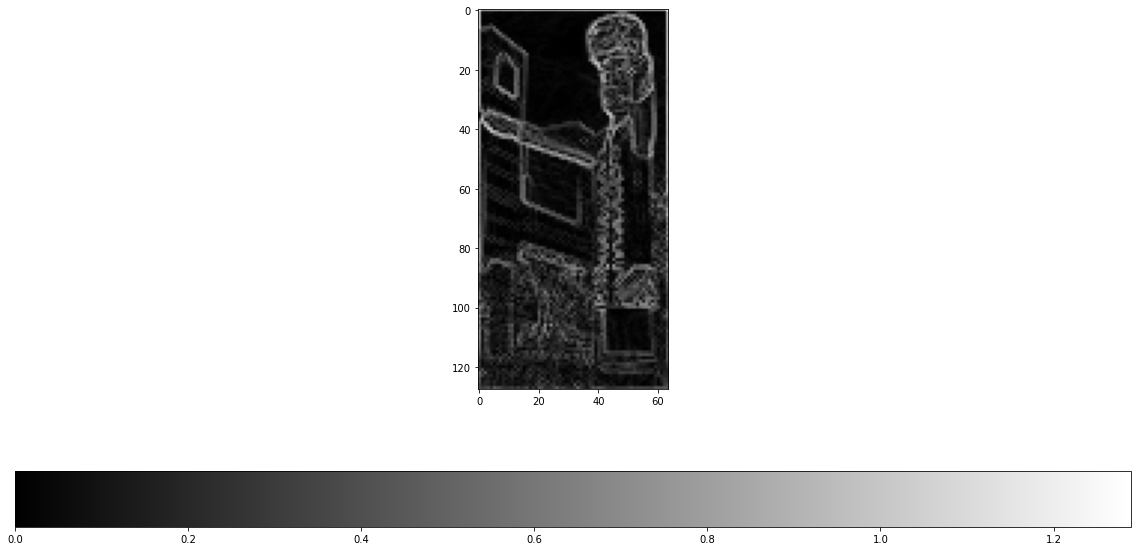

In [6]:
mag = np.sqrt((np.square(gradient_x) + np.square(gradient_y)))
#print(mag)
#here i use %180 to convert the values from 
orientation = np.arctan(gradient_y/gradient_x)*180/np.pi%180
# TO-DO (1 point): plot the magniture matrix
#

#plt.plot(mag)
#print(mag.size)
plt.figure(figsize=(20,10))
pltImg(mag)
# 
print("\nNOTE: The orientation angles in degrees should be between 0 and 180 degrees\n")
print("Thus, the maximum orientation angle is {:.4f} degrees" .format(np.nanmax(orientation)))
print("The minimum orientation angle is {} degrees \n" .format(np.nanmin(orientation)))
print("For reference, the first few elements of the orientation matrix are:\n\n{}" .format(orientation[0:3,0:3])) # check with the orientation reference provided. they should be 
#print(orientation)
# extremely similar


### **2.2 HOG: Creation of cells and Histograms of Oriented Gradients** (26 points)

We now have the orientation and magnitude images (matrices) of our grayscale input. The next step is to divide the grayscale input into 8x8 non-overlapping cells and create, for each cell, a histogram of oriented gradients. The HOG formation is illustrated in the image below (considering a small 3x3 cell): 

![](https://raw.githubusercontent.com/tunai/storage/master/images/teaching/ece%20473-536/A2/hog_formation.jpg)

In [7]:
# TO-DO (total 25 points): create the functions "my_hog" and "create_hist_cell" as specified
# in the templates below. 

# Tip: this implementation is going to be discussed during class on the week of February 8. 

# (10 points) my_hog function: this function is responsible for dividing the input image into non-overlapping
# cells of cell_size x cell_size.
def my_hog(img, cell_size, n_bin, mag, orientation):

  hog = []#np.zeros(img.shape[0])  # this is the list that will hold the HOG
  #print(hog.size)
  #dims =  # dimensions of the image

  #I THINK THIS IS SORT OF LIKE A FEATURE DESCRIPTOR VECTOR - i.e. the interest points or feature points
  #are the gradients (edges?) and their magnitude and orientation... the feature vector then is the 8x8 cell
  #that contains these values???

  # loop to divide the image into cells of cell_size x cell_size. Each cell is then 
  # used as input to the "create_hist_cell" function (see below). The output (HOG)  
  # is stored as a numpy ndarray in the "hog" list.
  #
  # Crop out the window 
  #range(start, stop, step)
  
  #Had some help from here https://stackoverflow.com/questions/22685274/divide-an-image-into-5x5-blocks-in-python-and-compute-histogram-for-each-block
  #since starting at zero and moving in steps of "cell_size" must subtract cell_size from the dimension length -NO I REMOVED THIS IT WAS WRONG
  for x in range(0,img.shape[0] , cell_size):
    for y in range(0,img.shape[1] , cell_size):
      window_mag= mag[x:x+cell_size,y:y+cell_size]
      #print(window_mag.size)
      #plt.imshow(window_mag, cmap='gray')
      window_orientation = orientation[x:x+cell_size,y:y+cell_size]
      #print(window_orientation.size)
      hog.append(create_hist_cell(window_mag, window_orientation, n_bin))
      
    
  return hog

#my_hog(img_totem_norm, cell_size, n_bin, mag, orientation)

# Crop out the window and calculate the histogram
#for r in range(0,test_image.shape[0] - windowsize_r, windowsize_r):
 #   for c in range(0,test_image.shape[1] - windowsize_c, windowsize_c):
  #      window = test_image[r:r+windowsize_r,c:c+windowsize_c]
  #      hist = numpy.histogram(window_mag, orientation_mag, n_bin)

# (15 points): this function will create a histogram of n_bins (9 by default) positions
# where the histogram of oriented gradients of a 8x8 cell is going to be stored.
# You can USE A MAXIMUM of "bin_size" iterations on this function's internal loop. 


def create_hist_cell(mag, orientation, bin_size):

    # each cell is going to have its own histogram of size 1x"bin_size"

    hist = []  # creates the empty histogram
    #print(hist.size)
    factor = 20 # the increment between boundaries of each bin of the cell histogram
    #limits =  # the boundaries between bins of the histogram

    # loop to, given an orientation and magnitude cell (small patch of cell_size x cell_size)
    # create a HOG.
    # You can use a MAXIMUM of "bin_size" iterations in this loop 
    #
    #
    #
    #
    #it goes to bin_size+1 because range will not include the last value (so this will only go from 1 to 9)
    for i in range(1, bin_size+1):
      #print(i)
      loc = 0
      loc = (np.where(np.logical_and(orientation >= i*20-20, orientation <= i*20)))
      hist.append(np.sum((mag[loc])))
      loc = 0

#for i in range(1, bin_size+1):
#      #print(i)
#      loc = 0
#      loc = (np.where(np.logical_and(orientation > i*20-20, orientation < i*20)))
#      hist.append(np.sum((mag[loc])))
#      if np.where(orientation == i*20):
#        loc1 = np.where(orientation == i*20)
#        #put it in bin-1
#        hist.insert(i-1, np.sum((hist.pop(i-1), np.sum(mag[loc1]))))
#        if i < 9:
#          hist.extend(np.sum(mag[loc1]))
#        loc1=0
        
      #print(hist)
 #     loc = 0
      #print(loc)

#def compute_hog_cell(n_orientations: int, magnitudes: np.ndarray, orientations: np.ndarray) -> np.ndarray:
#    """
#    Compute 1 HOG feature of a cell. Return a row vector of size `n_orientations`
#    """
#    bin_width = int(180 / n_orientations)
#    hog = np.zeros(n_orientations)
#    for i in range(orientations.shape[0]):
#        for j in range(orientations.shape[1]):
#            orientation = orientations[i, j]
#            lower_bin_idx = int(orientation / bin_width)
#            hog[lower_bin_idx] += magnitudes[i, j]

#    return hog / (magnitudes.shape[0] * magnitudes.shape[1])
 
    # note: there exists different ways to fill the histograms of oriented gradients. Some 
    # implementations use a weighted voting scheme for each pixel (i.e., a pixel would contribute 
    # to more than a single bin to avoid bias), while others simply add the values of the last 
    # bin in the first one (e.g., orientations between 160-180 also contributing to the 0-20 bin).
    # For simplicity, we do not do that here. Therefore, this implementation can be considered as
    # an approximation of the algorithm in [1].
    #print(len(hist))
    assert len(hist) == bin_size, 'The number of bins in this output histogram is incorrect.'
    return hist

# TO-DO (1 point): use your my_hog function to extract the histograms of oriented gradients 
# from the input image.

my_hog = my_hog(img_totem_norm, cell_size, n_bin, mag, orientation) 
print("For reference, the first 8x8 HOG is:\n {}" .format(my_hog[0]))
#print(my_hog[2])
print("\nThe length of ""my_hog"" (i.e. the number of 8x8 hogs performed) is: {}" .format(len(my_hog)))
# As a reference, the first HOG (i.e., HOG of the first 8x8 cell) should be similar to:
# my_hog[0] = [4.742218   0.17178032 2.086528   0.7064196  7.674342   0.684001
## 1.3927917  0.78699005 1.0897954 ]

For reference, the first 8x8 HOG is:
 [4.750061, 0.17178032, 2.0865278, 0.7064196, 7.6743417, 0.68400097, 1.3927917, 0.78699005, 1.0819521]

The length of my_hog (i.e. the number of 8x8 hogs performed) is: 128


### **2.3 HOG: 2 x 2 cell block normalization** (16 points)

The last step in calculating the HOG feature descriptor is to normalize blocks containing multiple cells to compensate for lighting and contrast changes, as described by the authors: "Gradient strengths vary over a wide range owing to local variations in illumination and foreground-background contrast, so effective local contrast normalization turns out to be essential for good performance." [1]

You are going to use blocks composed by 2 x 2 cells (i.e., 16x16 pixels for cell_size=8) and an L-2 norm normalization scheme. 

![](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-16x16-block-normalization.gif) [2]

[2] Mallick, Satya. "Histogram of Oriented Gradients." 2016. Available at: https://www.learnopencv.com/histogram-of-oriented-gradients/

Recall: for a given vector $x$ (or array of data in Python), the L2-norm is
given by: 

$\|x\|_{2}=(\sum_{i=1}^{N}|x_i|^2)^{1/2}=\sqrt{x_1^2+x_2^2+...+x_N^2}$

In [8]:
# TO-DO (15 points): implement the normalize16_16 function following the template provided. This function is going to 
# divide the HOG structure previously calculated into overlapping blocks of 2 x 2 cells (i.e., 16x16 pixels
# in the original image for for cell_size=8) and execute a L-2 normalization scheme in each of them.

#NOTE: normalizing a vector removes the scale so that the gradient magnitudes will not change with intensity changes
#thus it will be independent of lighting variations
#instead of normalizing the 1x9 hog (or essentially normalizing the gradients in the 8x8 cell),
#we will get better results by normalizing the gradients over a 16x16 cell which is 4 1x9 hogs concatenated to give 1x36 vector (1x9x4)

def normalize16_16(img, hog, cell_size):

    # preamble: consider a 128x64 image and 8x8 cells. this function's input is a sequential list representing the histograms
    # of oriented gradients from each 8x8 block of the image. They would be positioned as follows (each index
    # representing an 8x8 pixels block in the original image):
    # 0 1 2  3  4  5  6  7
    # 8 9 10 11 12 13 14 15
    #        ...
    # 112 113 ...    118 119
    # 120 121 ...    126 127
    #Create an empty array to index the histogram with
    index_arr = np.arange(128).reshape(16, -1)
    #print(index_arr[1,4])
    #print(index_arr.shape[0])
    #print(index_arr.shape[1])
    # algorithm: for position 0, a 16x16 block can be considered by retrieving the HOGs in positions 0,1,8,9. Similarly,
    # for position 1, the 16x16 cell would be equivalent to indexes 1,2,9,10. The last positions in this example are is 118, 
    # which will consider the hogs in indexes 118, 119, 126 and 127. The following for loop creates these indexes.
    # Note: at the end of a row (in the above representation), you need to jump straight to the next
    # row (there is no intermediate 16x16 block formed by the content of two distinct rows).
    index = 0
    #hog16_16 = []
    hog_normalized = []
    hog_flat = []
    for x in range(0,index_arr.shape[0]-1):     # Loop over every pixel of the image
      for y in range(0,index_arr.shape[1]-1):
        #I need it to move to the second row once it reaches 6 or 14 or...128)
        index= index_arr[x:x+cell_size, y:y+cell_size]
        index = index.flatten()
        ##print(index)
        hog16_16 = my_hog[index[0]] + my_hog[index[1]] + my_hog[index[2]] + my_hog[index[3]]
        hog_flat.append(hog16_16)
        hog16_16_L2 = np.sqrt(np.sum(np.square(hog16_16)))
        #print(hog16_16_L2)
        hog16_16_normalized = hog16_16/hog16_16_L2
        #print(hog16_16_normalized)
        hog_normalized.append(hog16_16_normalized)
        #print(len(hog16_16))
        index = 0
    hog_normalized = np.reshape(hog_normalized, (-1))
    #print(hog_normalized)
    print("The size of the normalized 1-D HOG vector is: {}" .format(hog_normalized.size))
    #print(hog_normalized[456])
    hog_flat = np.reshape(hog_flat, (-1))
    #print(hog_flat.size)

      
  

    #I created this "hog_flat" variable to contain un un-normalized 1x3780 long HOG vector just in case (it was not used)
    return hog_normalized, hog_flat

# TO-DO (1 point): use the normalize16_16 function to normalize your HOG features.
normalized_hog, hog_flat = normalize16_16(img_totem_norm, my_hog, 2)

The size of the normalized 1-D HOG vector is: 3780


### **2.4 HOG: Visualizing HOG features** (14 points)
Your HOG features should be represented as a row vector (i.e., flattened matrix). Considering a 128 x 64 image, cells of 8 x 8 pixels, HOGs of 9 bins and blocks of 2 x 2 cells, such row vector must have dimensions 1 x 3780. One could create a function to overlay each block on top of its corresponding position in the image and represent the "n_bin" different directions with arrows of changing lengths (magnitudes). However, in a simplified approach, we are going to use the "scikit-image" image processing library to calculate HOG features, compare them with our mannually calculated ones and display them. 

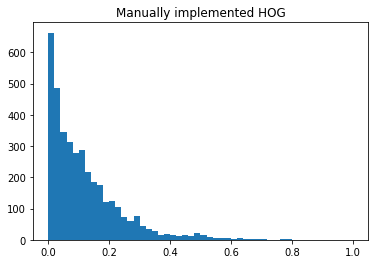

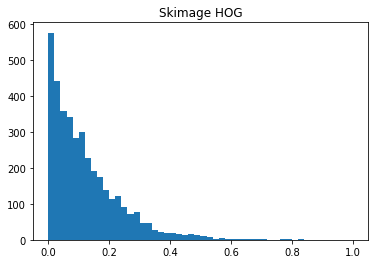

In [9]:
# TO-DO (2 points): create and plot a histogram with your row vector of HOG features. The histogram's plot
# should have 50 bins and span from 0 to 1 in the x-axis. 
# Note: you are calculating the regular histogram, not the cumulative one.  
#
#
plt.hist(normalized_hog, bins = 50, range=[0,1])
plt.title('Manually implemented HOG')
plt.show()

# TO-DO (2 points): use skimage's "hog" function to calculate the HOG of your input image using the 
# same hyper parameters (i.e., n_bin=9, cell_size=8, blocks of 2x2, L2-norm) of the rest of the 
# assignment. The output should be flattened to a row vector. The dimensions of such 
# vector must match those that you manually calculated. Specify that you desire to visualize 
# the results in an output image. 


fd, hog_image = hog(img_totem_rz, orientations=9, pixels_per_cell=(8, 8), visualize=True, cells_per_block=(2,2), block_norm='L2')

assert fd.size==normalized_hog.size, 'The dimensions of the HOG feature vectors do no match.'

# TO-DO (2 points): create and plot a 50-bin histogram with skimage's HOG features. 
# Bound the plot's x-axis values into the [0,1] range. 
# Display this plot for an approximate comparison with your recently calculated one. 
#
#
#
#
#plt.imshow(hog_image)
plt.hist(fd, bins=50, range=[0,1])
plt.title('Skimage HOG')
plt.show()
#print(fd.size)

**Similarity calculation**. In order to guarantee that visualizing scikit-images' HOG features represents well your mannualy calculated HOG features, you are now asked to compare the level of similarity between these two row of features. We will use cosine similarity to accomplish that. 

Recall: the cosine similarity is given by the cosine of angle $\alpha$ formed between two multi-dimensional vectors A and B:

$cosineSimilarity(A,B) = cos(\alpha)=\frac{A\bullet B}{\|A\|\times\|B\|}= \frac{(\sum_{i=1}^{n}A_i \times B_i)}{\sqrt{\sum_{i=1}^{n}A_i^2}\times\sqrt{\sum_{i=1}^{n}B_i^2}}$ 

The Cosine Similarity is 0.9516445839340555



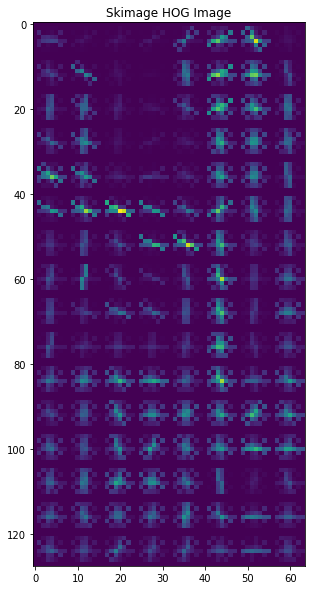

In [10]:
# TO-DO (6 points): MANNUALY calculate the cosine similarity between these two feature vectors
# (i.e., HOG features calculated mannualy and using skimage). The cosine similarity is simply
# the cosine of the angle formed between the two vectors. Since the cosine of 0 (i.e., when
# the vectors have the same orientation) is 1 (maximum), this measure reflects if
# two multi-dimensional vectors point in the same direction. 
# YOU CAN ONLY USE "np.sqrt" and "np.dot" in this calculation. 

# Note 1: this metric does not consider the magniture of the two input vectors, only the 
# angle between them. 

# Note 2: in the cosine similarity formula, the numerator represents dot product,
# while the denominator represents the product of L2-norms. 

#
#
#

hog_L2 = 0
skim_L2 = 0

for i in range(normalized_hog.size):
  hog_L2 += (normalized_hog[i])**2
  skim_L2 += (fd[i])**2
hog_L2 = np.sqrt(hog_L2)
skim_L2 = np.sqrt(skim_L2)


c_sim = np.dot(normalized_hog, fd)/(hog_L2*skim_L2)
print("The Cosine Similarity is {}\n".format(c_sim))


# TO-DO(1 point): print the cosine similarity calculated. If the HOG was correctly measured 
# both mannualy and automatically, the cosine similarity between "normalized_hog" and 
# "fd" should be higher than 0.95. To compensate for small differences, your 
# cosine similarity should be higher than AT LEAST 0.93.

assert c_sim>0.93, 'Cosine similarity lower than 0.93. Check your manual HOG calculations.'

# TO-DO (1 points): display the HOG image obtained as an output of skimage's "hog"
# function. Since the cosine similarity between the two HOG feature vectors is high,
# this is good approximation of HOG features you calculated mannualy.
#
#
plt.figure(figsize=(20,10))
plt.title('Skimage HOG Image')
plt.imshow(hog_image)



**End of the assignment!**